# 06 - Logistic Regression

In this exrecise, you construct a model that accurately predicts whether an individual makes more than \\$50,000 per year (or not). This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit organization to better understand how large of a donation to request (from that individual), or whether or not they should reach out at all to begin with. (A family with an income of less than \\$50,000 might not have that financial flexibility to start with.) While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publicly available features. 

The dataset for this exercise originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the 'fnlwgt' feature, as well as records with missing or ill-formatted entries.

## Data Exploration

Import the necessary Python libraries for solving this exercise: numpy, pandas, sklearn, matplotlib, and seaborn.

In [21]:
import numpy as np
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns

Prepare the filepath for the census data located in the shared folder.

In [22]:
from pathlib import Path
import os

data_dir = str(Path.home()) + r'/coursematerial/GIS/GeoDataScience'

filepath = os.path.join(data_dir, r'census.csv')

print(filepath)

/home/jovyan/coursematerial/GIS/GeoDataScience/census.csv


Actually read the data as comma separated values.

In [23]:
census = pd.read_csv(filepath)
census.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


Note that the last column from this dataset, **income**, will be our target label (whether an individual makes more than, or at most, \\$50,000 annually). Although not given directly as (binary) classes, the column determines a classification of people earning above \\$50,000 per year vs. those earning below. All other columns are features about each individual in the census database. 

Print the column names of the data frame with the attribute **columns**.

In [24]:
column_names = census.columns
column_names

Index(['age', 'workclass', 'education_level', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

**Description of columns / features:**
* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Give out some statistics with the method **describe()**.

In [25]:
census.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,1101.430344,88.595418,40.938017
std,13.217870,2.552881,7506.430084,404.956092,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


From this first glance at the data, we can see that we have primarily categorical data. Our target **income** is also currently given as a categorical field. Unfortunately, with categorical fields, we do not have a lot of visualization options (quite yet). However, it would be interesting to see the frequencies of each class, relative to the target of our classifier. To do this, we can use Seaborn's **countplot()** function to count the occurrences of each data point. Let's take a look at the counts of data.occupation and data.education — two likely predictors of income in the census data.

The **countplot()** function accepts either an **x** or a **y** argument to specify, if this is a bar plot or a column plot. The **hue** argument specifies a column for comparison; in this case we are concerned with the relationship of our categorical variables to the target **income**. And of course, the **data** (argument) is the census data frame.

[Text(0, 0, ' Adm-clerical'),
 Text(1, 0, ' Exec-managerial'),
 Text(2, 0, ' Handlers-cleaners'),
 Text(3, 0, ' Prof-specialty'),
 Text(4, 0, ' Other-service'),
 Text(5, 0, ' Sales'),
 Text(6, 0, ' Transport-moving'),
 Text(7, 0, ' Farming-fishing'),
 Text(8, 0, ' Machine-op-inspct'),
 Text(9, 0, ' Tech-support'),
 Text(10, 0, ' Craft-repair'),
 Text(11, 0, ' Protective-serv'),
 Text(12, 0, ' Armed-Forces'),
 Text(13, 0, ' Priv-house-serv')]

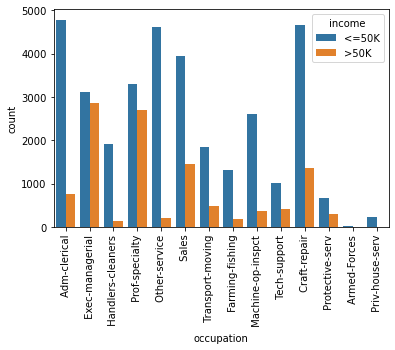

In [26]:
ax =sns.countplot(x='occupation',hue='income',data=census) 
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

Go ahead and explore other variables in the dataset, for example data.race and data.sex to see if those values are predictive of the level of income or not!

## Feature Set Exploration

A short investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.

In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

Print the values of the (four) computed variables.

**HINT:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [27]:
n_records = census['income'].shape[0]
n_greater_50k = np.sum(census['income']=='>50K')
n_at_most_50k = np.sum(census['income']=='<=50K')
greater_percent =(n_greater_50k* 100)/n_records
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.3f}%".format(greater_percent))


Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.784%


## Data Preparation for ML

Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with. However, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.


Separate the target variable from the features.

In [28]:
features_raw = census.drop('income',axis=1)
income_raw = census['income']
income_raw
features_raw

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,33,Private,Bachelors,13.0,Never-married,Prof-specialty,Own-child,White,Male,0.0,0.0,40.0,United-States
45218,39,Private,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States
45219,38,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States
45220,44,Private,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States


### Transforming Skewed Continuous Features

A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number. Machine learning algorithms can be sensitive to such distributions of values and can underperform, if the range is not properly normalized. Within the census dataset, two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features to show the skewed continuous features of the original data. Note the range of the values present and how they are distributed.

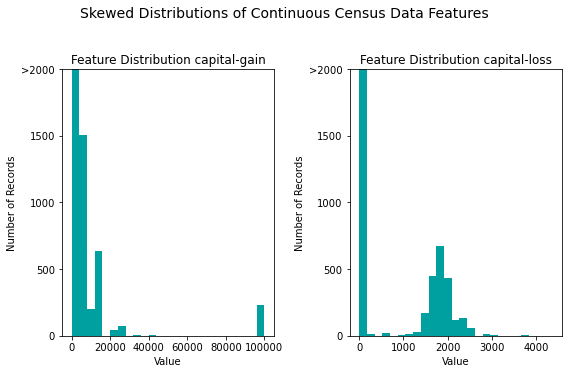

In [29]:
# Create figure
fig = plt.figure(figsize = (8,5));

 # Skewed feature plotting
for i, feature in enumerate(['capital-gain','capital-loss']):
    ax = fig.add_subplot(1, 2, i+1) # 
    ax.hist(census[feature], bins = 25, color = '#00A0A0')
    ax.set_title("Feature Distribution {}".format(feature), fontsize = 12)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 2000))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 14, y = 1.03)
fig.tight_layout()

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data, so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by extreme values. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Perform a transformation on the data using the **apply()** method on the (indexed) data frame (where only the respective columns are taken). The method takes a function as first parameter that is applied on the data. Here, a lambda function is defined in place of a function name. (A lambda function is a nameless function that takes in this example x as an input and performs some computation on it.)

In [30]:
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))
features_log_transformed[skewed]


,capital-gain,capital-loss
0,7.684784,0.0
1,0.000000,0.0
2,0.000000,0.0
3,0.000000,0.0
4,0.000000,0.0
...,...,...
45217,0.000000,0.0
45218,0.000000,0.0
45219,0.000000,0.0
45220,8.604471,0.0


Again, note the range of values and how they are distributed. 

In [31]:
features_log_transformed.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week
count,45222.000000,45222.000000,45222.000000,45222.000000,45222.000000
mean,38.547941,10.118460,0.740759,0.355489,40.938017
std,13.217870,2.552881,2.466527,1.595914,12.007508
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,11.512925,8.379539,99.000000


Visualize the new log distributions. The **range of values** is seen on the x-axis, and is much smaller than above.

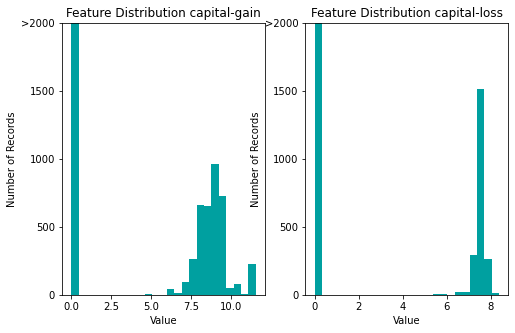

In [32]:
# Create figure
fig = plt.figure(figsize = (8,5)); 

 # Skewed feature plotting
for i, feature in enumerate(['capital-gain','capital-loss']):
    ax = fig.add_subplot(1, 2, i+1) # 
    ax.hist(features_log_transformed[feature], bins = 25, color = '#00A0A0')
    ax.set_title("Feature Distribution {}".format(feature), fontsize = 12)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.set_ylim((0, 2000))
    ax.set_yticks([0, 500, 1000, 1500, 2000])
    ax.set_yticklabels([0, 500, 1000, 1500, ">2000"])

### Normalizing Numerical Features

In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above). However, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss','hours-per-week']
features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] =scaler.fit_transform(features_log_minmax_transform[numerical])
features_log_minmax_transform.head(n = 5)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Categorical Features

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, machine learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.

In [34]:
features_final = pd.DataFrame(data = features_log_minmax_transform)
features_final = pd.get_dummies(features_final, drop_first=True)
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

95 total features after one-hot encoding.


Print all the encoded feature names.

In [35]:
print(encoded)

['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ Armed-Forces', 'occupation_ Craft-repair', 'occupation_ Exec-managerial', 'occupation_ Farming-fishing', 'occupation_ Handl

Convert the target label `'income_raw'` to numerical entries. For this you will use the [Label encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html?highlight=labelencoder#sklearn.preprocessing.LabelEncoder) class from the preprocesing module of sklearn.

In [36]:
income_categories = income_raw.drop_duplicates().tolist()
print(len(income_categories), 'categories')
print(income_categories)

2 categories
['<=50K', '>50K']


Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [37]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
income = labelencoder.fit_transform(income_raw)
income

array([0, 0, 0, ..., 0, 0, 1])

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.



In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_final,
income,
test_size = 0.2,
random_state = 0)
# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


## Training and Predicting

For training and prediction, we first import the necessary modules. Import `LogisticRegression` and  [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) and import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).

Instantiate a logistic regression object (learner). 

Be aware that there is a **C** parameter when constructing an object, which is the regularization strength. Experiment with different values for this parameter. (The default value is 1.0.)

Fit the learner to the training data. (This might take around 1 minute.)

Perform predictions on the test data `X_test`. 

Calculate the accuracy score from the predicted classes and the ground truth classes.